In [1]:
import sys
#Change path specificly to your directories
sys.path.insert(1, '/home/fishial/Fishial/Object-Detection-Model')

import time
import torch
import os
import cv2
import math 
import matplotlib.pyplot as plt
import torchvision.models as models
import numpy as np
from torch import nn
from torch.optim import Optimizer, SGD
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from sklearn.neighbors import KDTree
import pandas as pd
from module.classification_package.src.utils import read_json, save_json
from module.classification_package.interpreter_classifier import ClassifierFC
from module.classification_package.interpreter_embeding import EmbeddingClassifier
# from module.classification_package.interpreter_embeding_data import EmbeddingClassifierData
from module.segmentation_package.interpreter_segm import SegmentationInference
from module.classification_package.src.dataset import FishialDataset
# from module.segmentation_package.src.utils import resize_image
from PIL import Image
import numpy as np
import random
import sklearn.metrics.pairwise
import scipy.spatial.distance
import copy
import json
import time
import requests
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from os import listdir
from module.classification_package.src.utils import read_json, save_json
from os.path import isfile, join
# TRESHOLD 40.6256
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [2]:
from module.segmentation_package.src.utils import get_mask

def get_mask_by_ann(data, ann, main_folder):
    polygon_tmp = []
    for pt in range(int(len(ann['segmentation'][0])/2)):
        polygon_tmp.append([int(ann['segmentation'][0][pt * 2]), int(ann['segmentation'][0][pt * 2 + 1])])
    img = get_image(data, main_folder, ann['image_id'])
    mask = get_mask(img, np.array(polygon_tmp))
    
    return mask, ann['image_id']

def get_image(data, folder_main, id):
    for img in data['images']:
        if img['id'] == id:
            return cv2.cvtColor(cv2.imread(os.path.join(folder_main, img['file_name'])), cv2.COLOR_BGR2RGB)
        

def hconcat_resize_min(im_list, interpolation=cv2.INTER_CUBIC):
    h_min = min(im.shape[0] for im in im_list)
    im_list_resize = [cv2.resize(im, (int(im.shape[1] * h_min / im.shape[0]), h_min), interpolation=interpolation)
                      for im in im_list]
    return cv2.hconcat(im_list_resize)

def get_image_by_ann_id(full_data, ann_id, main_folder = r'/home/fishial/Fishial/dataset/fishial_collection/data'):
    for i in full_data['annotations']:
        if i['id'] == ann_id:
            image, image_id = get_mask_by_ann(full_data, i, main_folder)
            return image, image_id
        

def __remove_dupliceta(mylist):
        seen = set()
        newlist = []
        for item in mylist:
            t = tuple(item)
            if t[0] not in seen:
                newlist.append(item)
                seen.add(t[0])
        return newlist

In [3]:
folder_path = r'/home/fishial/Fishial/output/classification/resnet_18_186_train_08_11'
data_base  = torch.load(os.path.join(folder_path, 'data_train.json_embedding_dep_fixed.pt')).to('cpu')
data_base_labels = read_json(os.path.join(folder_path, 'data_train.json_labels_dep_fixed.json'))
data_base_idx = read_json(os.path.join(folder_path, 'data_train.json_idx_dep_fixed.json'))


In [4]:
full_data = read_json(r'/home/fishial/Fishial/dataset/export/fixed_invalid.json')

### Images whose distance is very low but has a different class

In [ ]:
for class_id_a, vec_per_class_a in enumerate(data_base):
    for a_idx, a in enumerate(vec_per_class_a):
        if a.sum() > 10000: continue
        src_img, src_img_id = get_image_by_ann_id(full_data, data_base_idx[str(class_id_a)]['annotation_id'][a_idx])
        print(f'CRNT: {class_id_a}/{a_idx}', end='\r')
        diff = torch.abs(data_base - a).sum(dim=2)
        val, indi = torch.sort(diff)
        
        for idx, i in enumerate(val):
            
            distancess = [round(asd, 4) for asd in i.to('cpu').numpy() if asd < 10000]
            mean_tmp_dist = np.mean(distancess)
            if class_id_a != idx:
                for disst_id, disst in enumerate(distancess):
                    if disst < 20:
                        ann_iddds = data_base_idx[str(idx)]['annotation_id'][indi[idx][int(indi[idx][disst_id])]]
                        
                        dst_img, dst_img_id = get_image_by_ann_id(full_data, ann_iddds)
                        print(f' distance: {round(disst, 4)} ')
                        print(f' ann id:' + data_base_idx[str(class_id_a)]['annotation_id'][a_idx] +  f' image id: {src_img_id}')
                        print(f' ann id: {ann_iddds} | image id {dst_img_id}')
                        print(f' target/founded: {data_base_labels[str(class_id_a)]}/{data_base_labels[str(idx)]}')
                        plt.imshow(hconcat_resize_min([src_img, dst_img]))
                        plt.show()

In [5]:
data_checker = { data_base_labels[str(label_id)]: [] for label_id in range(len(data_base)) }
for class_id_a, vec_per_class_a in enumerate(data_base):
    for a_idx, a in enumerate(vec_per_class_a):
        if a.sum() > 10000: continue
        print(f'crnt: {a_idx}/{class_id_a}', end='\r')
        data_checker[data_base_labels[str(class_id_a)]].append([])
        for b_idx, b in enumerate(vec_per_class_a):
            if b.sum() > 10000: continue
            if a_idx == b_idx: continue
            emb_dist = (a - b).abs().sum()
            data_checker[data_base_labels[str(class_id_a)]][a_idx].append(float(emb_dist))
#             print(class_id_a, a_idx,len(data_checker[data_base_labels[str(class_id_a)]][a_idx]))

### Images whose average distance is 50% or more different from the class average,

num: 1 div: 1.75 Class: Paralabrax maculatofasciatus ann id: a3cd46c8-9d79-53c3-a0cd-3784987fb65d img id: 301222


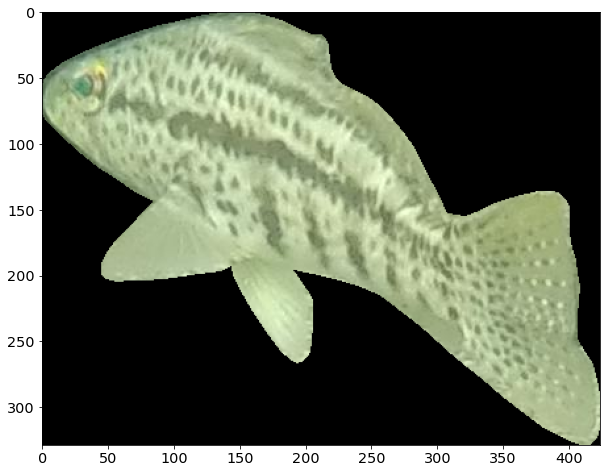

num: 2 div: 1.86 Class: Anguilla anguilla ann id: f6a04fb9-47b0-522d-ac00-62824e45e3a8 img id: 372728


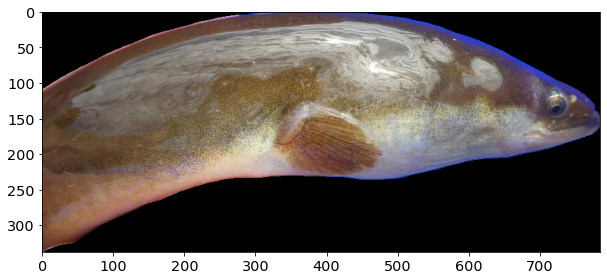

num: 3 div: 1.93 Class: Paralichthys dentatus ann id: b4d5c064-a4c2-52fc-9d6a-940fab7f8fca img id: 94758


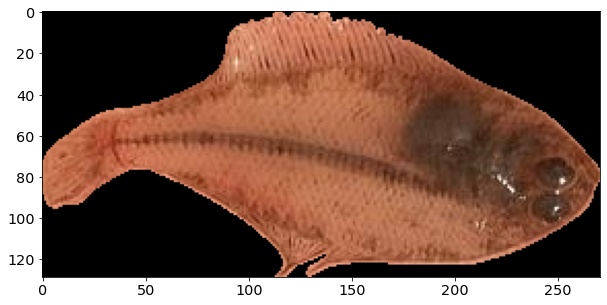

num: 4 div: 1.71 Class: Barbus barbus ann id: d0c94326-32a9-5ce3-9023-5a1954db1062 img id: 157609


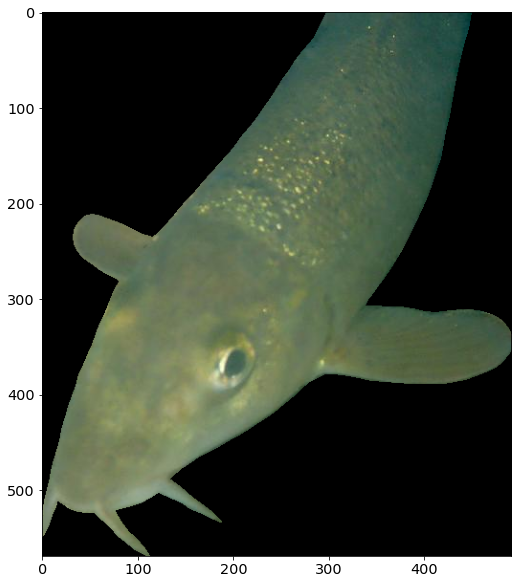

num: 5 div: 1.99 Class: Paralichthys californicus ann id: fce4746c-f943-5a53-b96d-fcd2570a2635 img id: 304072


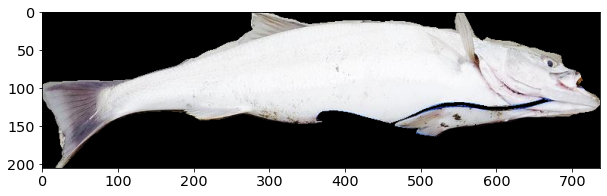

num: 6 div: 1.77 Class: Pogonias cromis ann id: ff51a7ca-0fb6-5dc9-af30-9d24f5b1da29 img id: 31183


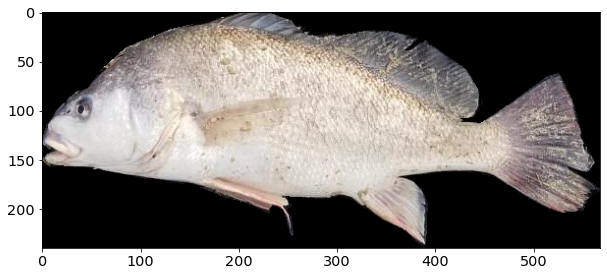

num: 7 div: 1.82 Class: Pogonias cromis ann id: 5b0c3ff0-3805-5879-9b30-ce1757958a54 img id: 33143


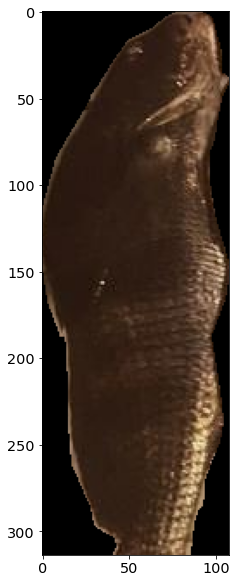

num: 8 div: 1.8 Class: Salvelinus fontinalis ann id: 05d6baa8-7824-54e2-b689-1ace2c48e93a img id: 32569


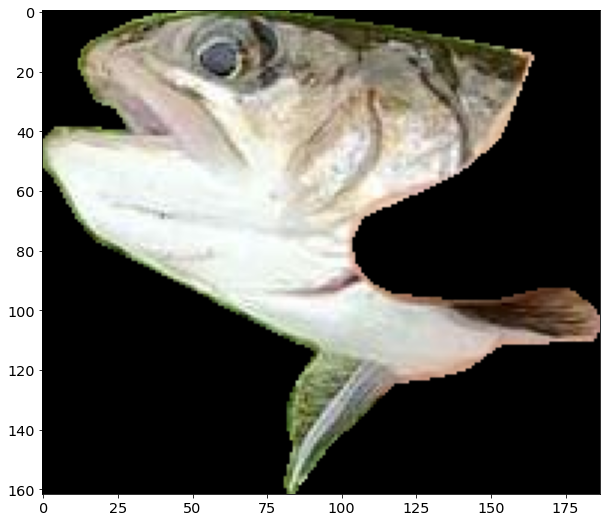

num: 9 div: 1.89 Class: Cynoscion nebulosus ann id: 64454585-8ceb-54df-aa36-12e828f650c8 img id: 27568


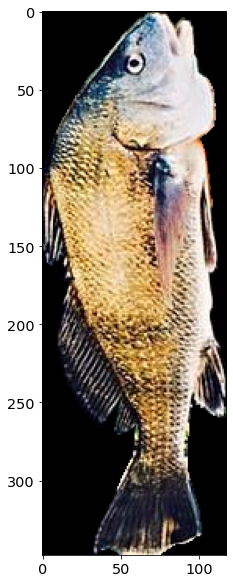

num: 10 div: 1.77 Class: Merlangius merlangus ann id: eda022f1-6ebd-586b-8fe7-5f938f63d03e img id: 31171


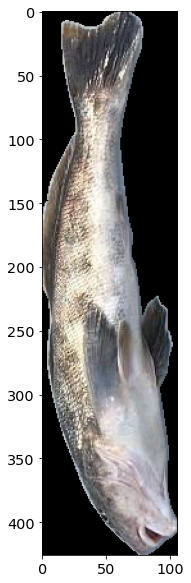

num: 11 div: 1.82 Class: Caranx hippos ann id: 6ffaf510-ae47-51a9-b7d2-51296e6f1435 img id: 41316


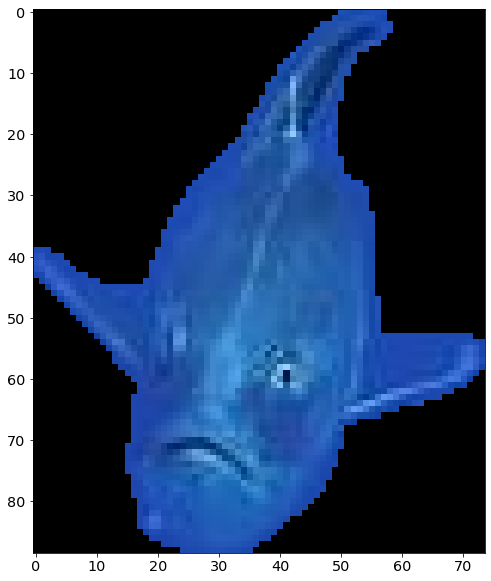

num: 12 div: 1.77 Class: Lutjanus bohar ann id: 9f78f125-e8fa-569a-b32b-f923eae92c63 img id: 137121


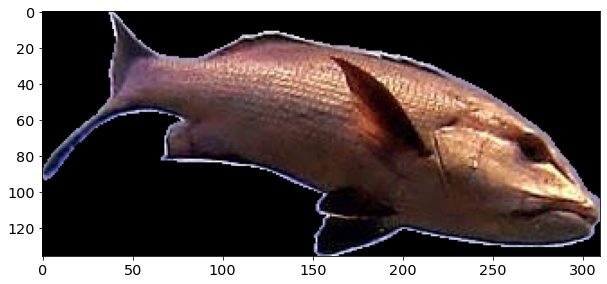

num: 13 div: 1.84 Class: Seriola lalandi ann id: 13525fcb-c9a4-5b23-8f97-7e3deb2d9bf2 img id: 342299


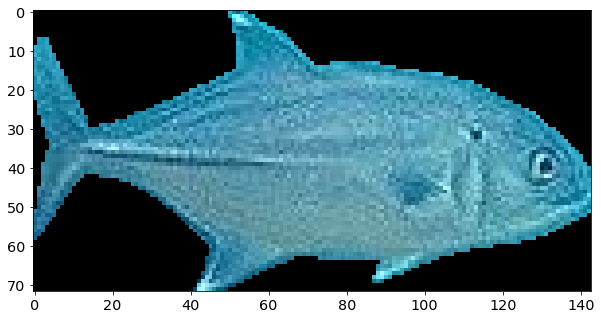

num: 14 div: 1.76 Class: Micropterus salmoides ann id: 3d7a0453-7ddd-5be9-832f-09061164df9a img id: 14393


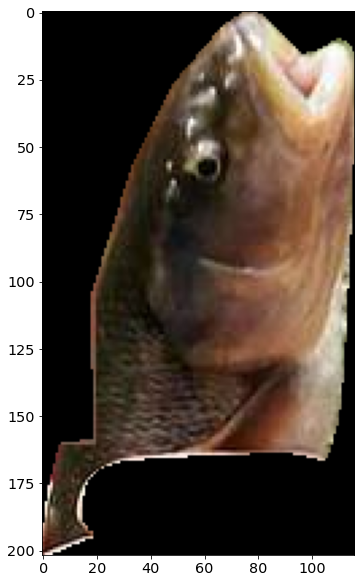

num: 15 div: 2.24 Class: Oreochromis aureus ann id: 30696d71-30d5-5970-8077-e05f45ee6c06 img id: 167476


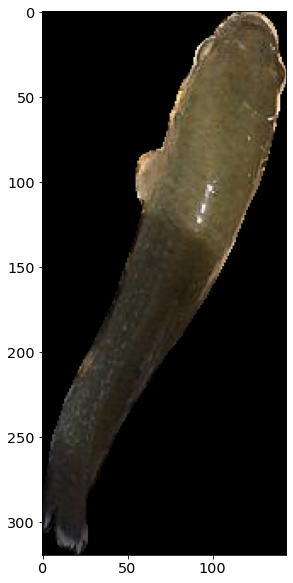

num: 16 div: 2.22 Class: Mugil curema ann id: 0c369371-aaef-5594-b0a2-087f4c9ab4c1 img id: 6353


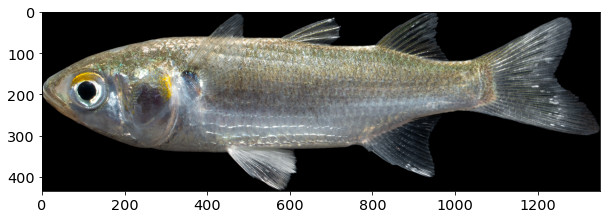

num: 17 div: 1.77 Class: Scomberomorus maculatus ann id: 68e1a76e-1f54-58fa-a987-61bb3246dee8 img id: 28447


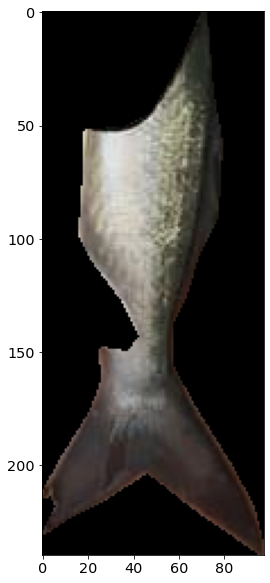

num: 18 div: 2.08 Class: Ictalurus furcatus ann id: 7c27a0a7-1b26-5344-99b6-334329122ebd img id: 55594


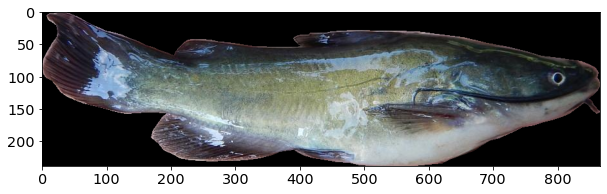

num: 19 div: 1.73 Class: Lepomis macrochirus ann id: 4063af91-0cc7-5bf3-bb83-87da0e417547 img id: 27834


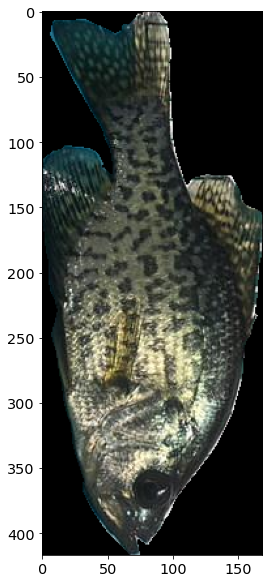

num: 20 div: 1.79 Class: Lutjanus analis ann id: 4cd0a405-1d2a-5304-9ea8-5c2ac8820b0e img id: 28643


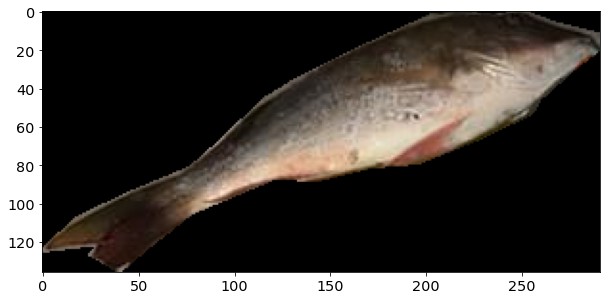

num: 21 div: 1.83 Class: Micropterus dolomieu ann id: b6d447f1-8795-5aba-8525-bf7865041851 img id: 16929


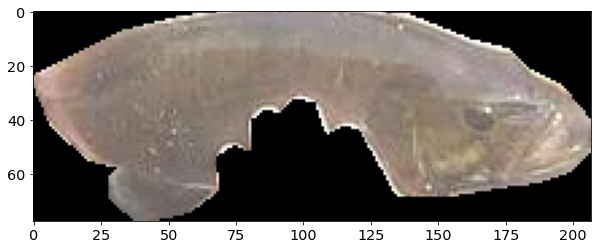

num: 22 div: 1.88 Class: Micropterus dolomieu ann id: 9ef75c69-baf2-5a76-98e5-a00767582c22 img id: 16990


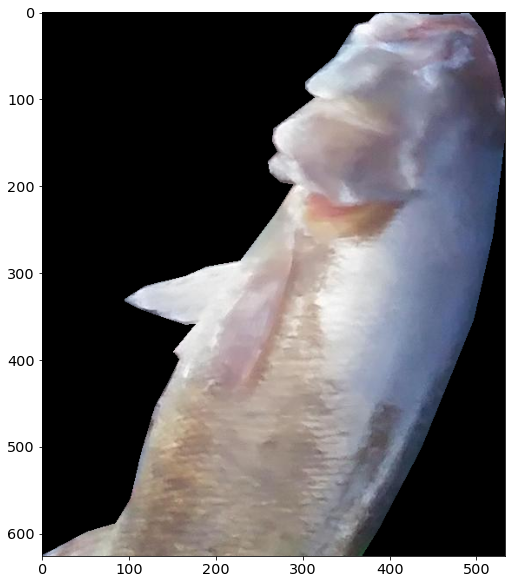

num: 23 div: 1.76 Class: Amia calva ann id: 74f71d72-485a-5086-b999-5ee6302af99e img id: 6282


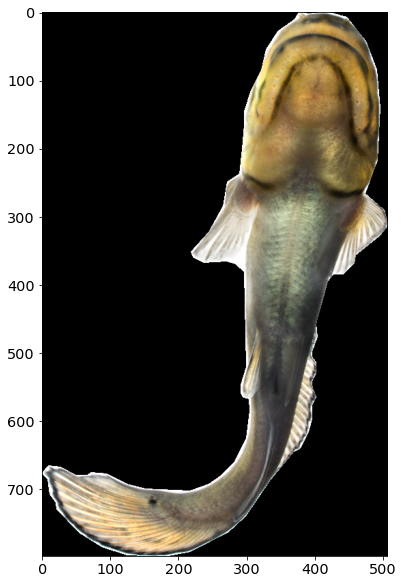

num: 24 div: 1.92 Class: Morone chrysops ann id: 5f5e20e7-c775-5d20-98e1-abb59a248324 img id: 100173


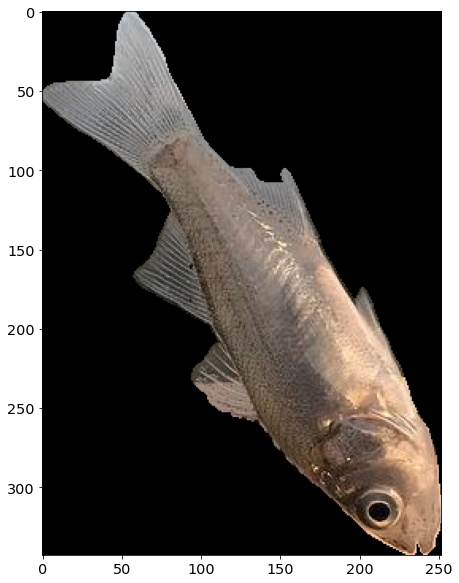

num: 25 div: 2.07 Class: Seriola dumerili ann id: 34af6584-a073-5390-8e62-d2dd0d9a0773 img id: 212806


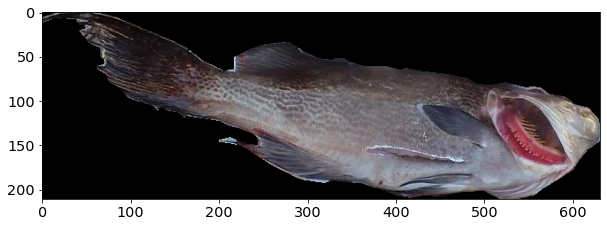

num: 26 div: 1.7 Class: Acanthopagrus butcheri ann id: 32e727ae-7d14-5de3-b4fd-777da7c9269a img id: 440139


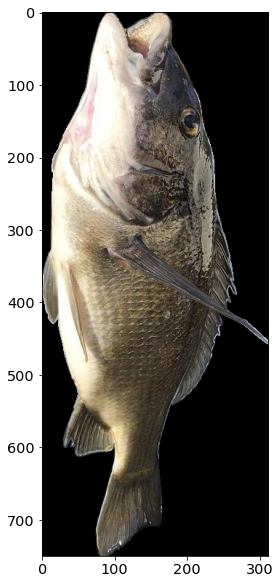

num: 27 div: 1.75 Class: Mycteroperca microlepis ann id: 516cc798-6da0-50ac-8ed3-624abd74a7b5 img id: 6394


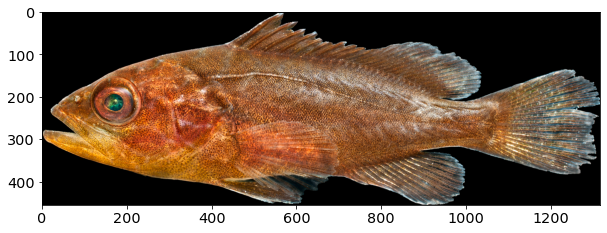

num: 28 div: 1.96 Class: Ameiurus nebulosus ann id: 328d9c70-0947-505a-b8eb-91a318fdd902 img id: 62488


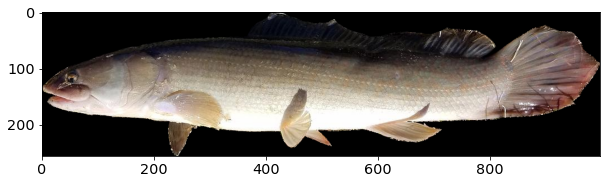

num: 29 div: 1.87 Class: Coryphaena hippurus ann id: f1d173a0-cf74-521d-96c9-c1cb35ab1e21 img id: 6443


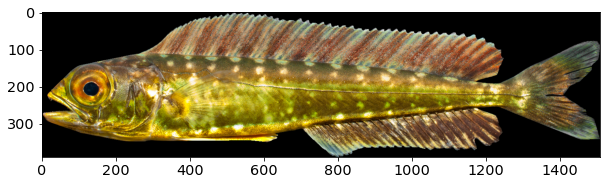

num: 30 div: 1.84 Class: Coryphaena hippurus ann id: 0dd370ac-2d90-5200-9135-edd820a355bc img id: 6459


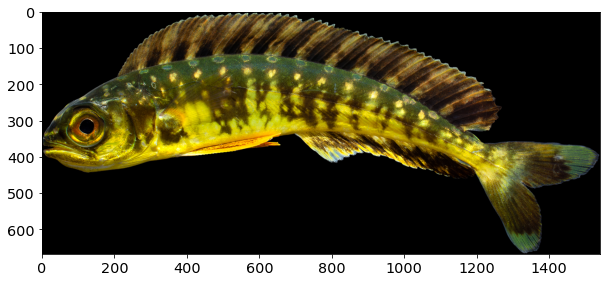

num: 31 div: 1.71 Class: Stenotomus chrysops ann id: 9617a2c6-ad0b-5123-bc81-f76203565837 img id: 32946


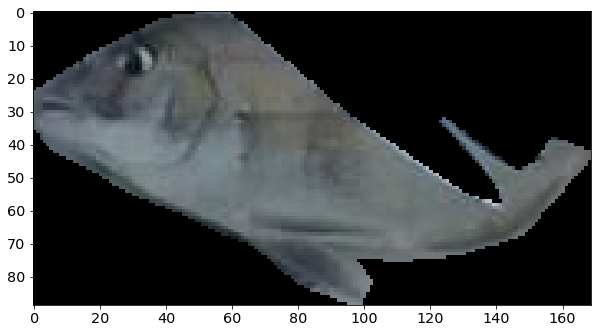

num: 32 div: 1.79 Class: Lutjanus argentimaculatus ann id: 0b9a5dc7-4370-5394-8224-2049f893f228 img id: 38088


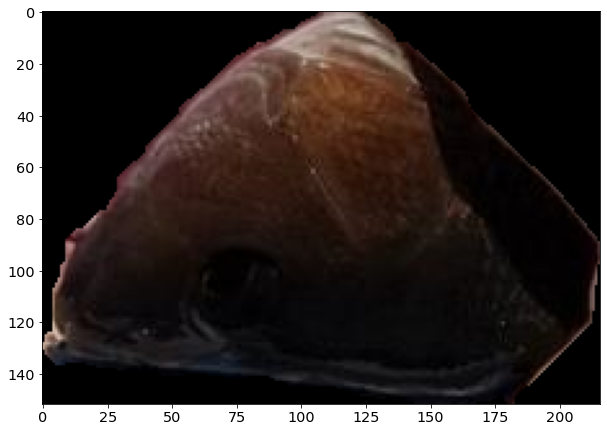

num: 33 div: 1.85 Class: Mugil cephalus ann id: 403046b5-c591-5104-ac61-8b4ce5c67710 img id: 250514


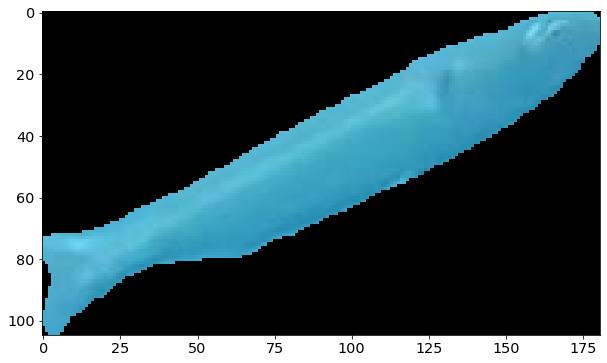

num: 34 div: 1.7 Class: Tinca tinca ann id: fc1c5ef9-390c-560f-af95-bb69ee6faf93 img id: 284533


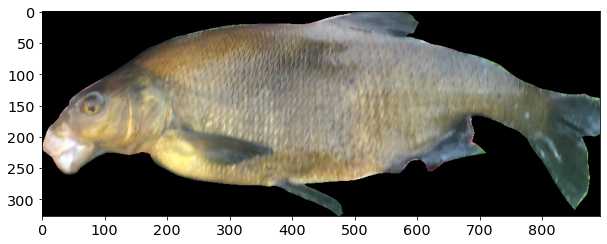

In [7]:
num = 0
for idx, i in enumerate(data_checker):
    mean_per_image = [np.mean(z) for z in data_checker[i]]
    mean_per_class = np.mean(mean_per_image)
    for k_idx, k in enumerate(mean_per_image):
        if k/mean_per_class > 1.7:
            src_img, src_img_id = get_image_by_ann_id(full_data, data_base_idx[str(idx)]['annotation_id'][k_idx])
            num += 1l
            print(f"num: {num} div: {round(float(k/mean_per_class), 2)} Class: {i} ann id: " + 
                  data_base_idx[str(idx)]['annotation_id'][k_idx] +  f" img id: {src_img_id}")
            plt.imshow(src_img)
            plt.show()

In [ ]:
top_k = 20

data_truth = {}
for class_id_a, vec_per_class_a in enumerate(data_base_train):
    print(f"{class_id_a}: {len([0 for vec in vec_per_class_a if vec.sum() < 10000])}: {data_base_labels[str(class_id_a)]}")
    for a_idx, a in enumerate(vec_per_class_a):
        if a.sum() > 10000: continue
        print(f'CRNT: {class_id_a}/{a_idx}', end='\r')
        diff = (data_base_train - a).pow(2).sum(dim=2).sqrt()
        val, indi = torch.sort(diff)
        class_lib = []
        for idx, i in enumerate(val):
            #return only top N(12) elements from each class
            for dist_idx, dist in enumerate(i[:25]):
                if dist == 0.0: continue 
                if dist < 4:
                    class_lib.append([idx, dist,data_base_idx[str(idx)]['annotation_id'][indi[idx][dist_idx]] ])
        topest = sorted(class_lib, key=lambda x: x[1], reverse=False)
        my_dict = [[i[0], [iii[0] for iii in topest[:top_k]].count(i[0]), i[1], i[2]] for i in topest[:top_k]]
        my_dict = sorted(my_dict, key=lambda x: x[1], reverse=True)
        my_dict = [[match[0], match[2], match[3]] for match in my_dict]
        my_dict = my_dict[:1] + sorted(my_dict[1:], key=lambda x: x[1], reverse=True)
        
        data_truth.update({
            data_base_idx[str(class_id_a)]['annotation_id'][a_idx]: {
                'label': data_base_labels[str(class_id_a)],
                'pred': []
            }
        })
        
        
        for asd in my_dict: 
            if asd[0] == class_id_a: continue
            data_truth[data_base_idx[str(class_id_a)]['annotation_id'][a_idx]]['pred'].append({
                'label': data_base_labels[str(asd[0])],
                'dst': asd[2]
            })


In [ ]:
cnt = 0
print("Nr  | annotation_id:                     | image_id: | label in COCO: | supposed by AI: |")
for idx, i in enumerate(data_truth):
#     print(len(data_truth[i]['ann_id']))
    
    if len(data_truth[i]['pred'])> 3:
        cnt+= 1
        
        img = get_image_by_ann_id(full_data, i)
        print(" {} | {} | {} | {} | {}".format(
            cnt, 
            i,
            img[1], 
            data_truth[i]['label'], 
            list(set([ann['label'] for ann in data_truth[i]['pred']]))[0]
        ))
        
        plt.imshow(img[0])
        plt.show()
#         for ann in data_truth[i]['pred']:
#             print("name dst: ", ann['label'], ann['dst'])
#             img = get_image_by_ann_id(full_data, ann['dst'])
#             plt.imshow(img[0])
#             plt.show()
#         print(20 * "=")
#     print(data_truth[i])
#     print("--")
#     for zxc in range(len(data_truth[i]['pred'])):
#         if len(data_truth[i]['pred'][zxc])> 0:
            
#             print("src: {} ann: {}".format(data_base_labels[str(idx)], data_truth[i]['ann_id'][zxc]))
#             print(data_truth[i]['pred'][zxc])
#             img = get_image_by_ann_id(full_data, data_truth[i]['ann_id'][zxc])
#             plt.imshow(img[0])
#             plt.show()
#             for xcv in data_truth[i]['pred'][zxc]:
#                 print("dst id: {}  ann id {}".format(data_base_labels[str(xcv[0])], xcv[1]))
#                 img = get_image_by_ann_id(full_data, xcv[1])
#                 plt.imshow(img[0])
#                 plt.show()
            
# #     ASDAS = [z for z in data_truth[i][0]]
# #     print("Main: ",data_base_labels[str(i)], len([0 for vec in data_base_test[i] if vec.sum() < 10000]), len(ASDAS))
# #     unique = set(ASDAS)
# #     for z in unique:
# #         print("    :  {} | {}".format(data_base_labels[str(z)], len([0 for vec in data_base_train[z] if vec.sum() < 10000])))